## Importing the Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
np.random.seed(42)

## Training the Physics Informed Neural Network

In [3]:
N_train = 2000

x_vals = np.random.uniform(0, 1, (N_train, 1))
t_vals = np.random.uniform(0, 1, (N_train, 1))
u_true = np.sin(np.pi * x_vals) * np.exp(-np.pi**2 * t_vals)

x_tensor = tf.convert_to_tensor(x_vals, dtype=tf.float32)
t_tensor = tf.convert_to_tensor(t_vals, dtype=tf.float32)
u_true_tensor = tf.convert_to_tensor(u_true, dtype=tf.float32)

train_inputs = tf.concat([x_tensor, t_tensor], axis=1)

In [4]:
num_points = 100

x_line = np.linspace(0, 1, num_points)
t_line = np.linspace(0, 1, num_points)
X_grid, T_grid = np.meshgrid(x_line, t_line)
x_test_flat = X_grid.flatten().reshape(-1, 1)
t_test_flat = T_grid.flatten().reshape(-1, 1)
u_true_grid = np.sin(np.pi * x_test_flat) * np.exp(-np.pi**2 * t_test_flat)

x_test_tensor = tf.convert_to_tensor(x_test_flat, dtype=tf.float32)
t_test_tensor = tf.convert_to_tensor(t_test_flat, dtype=tf.float32)
test_inputs = tf.concat([x_test_tensor, t_test_tensor], axis=1)
u_true_test_tensor = tf.convert_to_tensor(u_true_grid, dtype=tf.float32)

In [5]:
class CustomPINN(tf.keras.Model):
    def __init__(self):
        super(CustomPINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.hidden2 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.hidden3 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.out_layer = tf.keras.layers.Dense(1, activation=None, kernel_initializer='glorot_uniform')

    def call(self, inputs):

        x_component = inputs[:, 0:1]
        t_component = inputs[:, 1:2]

        combined = tf.concat([x_component, t_component], axis=1)
        z1 = self.hidden1(combined)
        z2 = self.hidden2(z1)
        z3 = self.hidden3(z2)
        output = self.out_layer(z3)
        return output

def compute_physics_loss(model, x_input, t_input):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_input)
        tape.watch(t_input)
        predictions = model(tf.concat([x_input, t_input], axis=1))
        d_pred_dx = tape.gradient(predictions, x_input)
        d2_pred_dx2 = tape.gradient(d_pred_dx, x_input)
        d_pred_dt = tape.gradient(predictions, t_input)
    del tape
    alpha = 1.0
    residual = d_pred_dt - alpha * d2_pred_dx2
    return tf.reduce_mean(tf.square(residual))

In [6]:
pinn_model = CustomPINN()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [7]:
total_epochs = 5000

for epoch in range(total_epochs):
    with tf.GradientTape() as grad_tape:
        p_loss = compute_physics_loss(pinn_model, x_tensor, t_tensor)
        d_loss = tf.reduce_mean(tf.square(pinn_model(train_inputs) - u_true_tensor))
        combined_loss = d_loss + 0.1 * p_loss
    gradients = grad_tape.gradient(combined_loss, pinn_model.trainable_variables)
    adam_optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))
    if epoch % 500 == 0:
        print(f"Epoch {epoch:05d}/{total_epochs} | Total Loss: {combined_loss.numpy():.6f}  "
              f"Data Loss: {d_loss.numpy():.6f}  Physics Loss: {p_loss.numpy():.6f}")

Epoch 00000/5000 | Total Loss: 0.030605  Data Loss: 0.027709  Physics Loss: 0.028957
Epoch 00500/5000 | Total Loss: 0.002437  Data Loss: 0.001934  Physics Loss: 0.005030
Epoch 01000/5000 | Total Loss: 0.000848  Data Loss: 0.000592  Physics Loss: 0.002562
Epoch 01500/5000 | Total Loss: 0.000377  Data Loss: 0.000254  Physics Loss: 0.001231
Epoch 02000/5000 | Total Loss: 0.000198  Data Loss: 0.000115  Physics Loss: 0.000830
Epoch 02500/5000 | Total Loss: 0.000119  Data Loss: 0.000058  Physics Loss: 0.000607
Epoch 03000/5000 | Total Loss: 0.000072  Data Loss: 0.000030  Physics Loss: 0.000425
Epoch 03500/5000 | Total Loss: 0.000047  Data Loss: 0.000018  Physics Loss: 0.000286
Epoch 04000/5000 | Total Loss: 0.000033  Data Loss: 0.000012  Physics Loss: 0.000211
Epoch 04500/5000 | Total Loss: 0.000023  Data Loss: 0.000008  Physics Loss: 0.000146


In [8]:
u_pred_test = pinn_model(test_inputs)
u_pred_grid = u_pred_test.numpy().reshape(num_points, num_points)
u_true_grid_reshaped = u_true_grid.reshape(num_points, num_points)

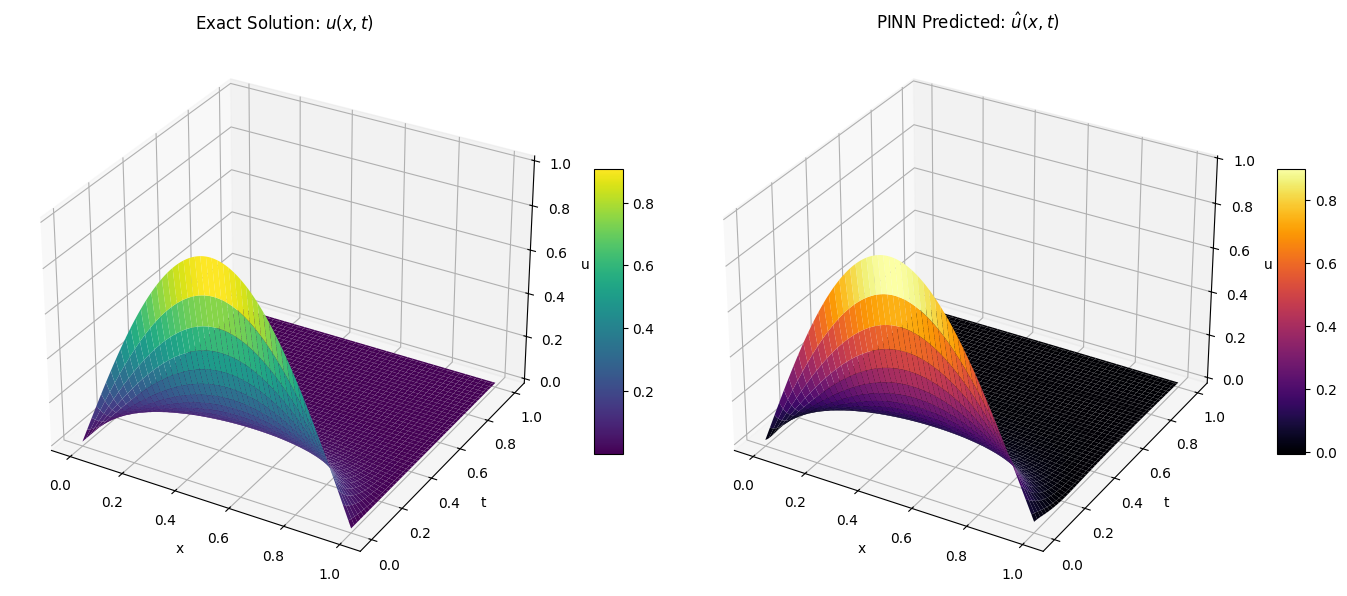

In [9]:
fig = plt.figure(figsize=(14, 6))

# True Solution Plot
ax_left = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax_left.plot_surface(X_grid, T_grid, u_true_grid_reshaped, cmap='viridis', edgecolor='none')
ax_left.set_title("Exact Solution: $u(x,t)$")
ax_left.set_xlabel("x")
ax_left.set_ylabel("t")
ax_left.set_zlabel("u")
fig.colorbar(surf1, ax=ax_left, shrink=0.5, aspect=10)

# Predicted Solution Plot
ax_right = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax_right.plot_surface(X_grid, T_grid, u_pred_grid, cmap='inferno', edgecolor='none')
ax_right.set_title("PINN Predicted: $\\hat{u}(x,t)$")
ax_right.set_xlabel("x")
ax_right.set_ylabel("t")
ax_right.set_zlabel("u")
fig.colorbar(surf2, ax=ax_right, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

## Training Data-Only Neural Network

In [10]:
N_samples = 2000

x_train = np.random.uniform(0, 1, (N_samples, 1))
t_train = np.random.uniform(0, 1, (N_samples, 1))

u_exact_train = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_train_tf = tf.convert_to_tensor(u_exact_train, dtype=tf.float32)

train_features = tf.concat([x_train_tf, t_train_tf], axis=1)

In [11]:
num_points = 100

x_line = np.linspace(0, 1, num_points)
t_line = np.linspace(0, 1, num_points)
X_grid, T_grid = np.meshgrid(x_line, t_line)
x_test = X_grid.flatten().reshape(-1, 1)
t_test = T_grid.flatten().reshape(-1, 1)
u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)

x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)
test_features = tf.concat([x_test_tf, t_test_tf], axis=1)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)

In [12]:
class StandardNN(tf.keras.Model):
    def __init__(self):
        super(StandardNN, self).__init__()
        # Three hidden layers with 100 neurons each
        self.fc1 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.fc2 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.fc3 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.output_layer = tf.keras.layers.Dense(1, activation=None, kernel_initializer='glorot_uniform')

    def call(self, inputs):

        z = self.fc1(inputs)
        z = self.fc2(z)
        z = self.fc3(z)
        return self.output_layer(z)

In [13]:
model = StandardNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [14]:
epochs = 5000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = model(train_features)
        loss_value = tf.reduce_mean(tf.square(predictions - u_exact_train_tf))
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch:04d} | Loss: {loss_value.numpy():.6e}")

Epoch 0000 | Loss: 2.428307e-02
Epoch 0500 | Loss: 1.403046e-03
Epoch 1000 | Loss: 1.613273e-04
Epoch 1500 | Loss: 5.736647e-05
Epoch 2000 | Loss: 3.313258e-05
Epoch 2500 | Loss: 2.242276e-05
Epoch 3000 | Loss: 1.695881e-05
Epoch 3500 | Loss: 1.260131e-05
Epoch 4000 | Loss: 9.474701e-06
Epoch 4500 | Loss: 2.258560e-04


In [15]:
u_pred = model(test_features).numpy().reshape(num_points, num_points)
u_exact_grid = u_exact_test.reshape(num_points, num_points)

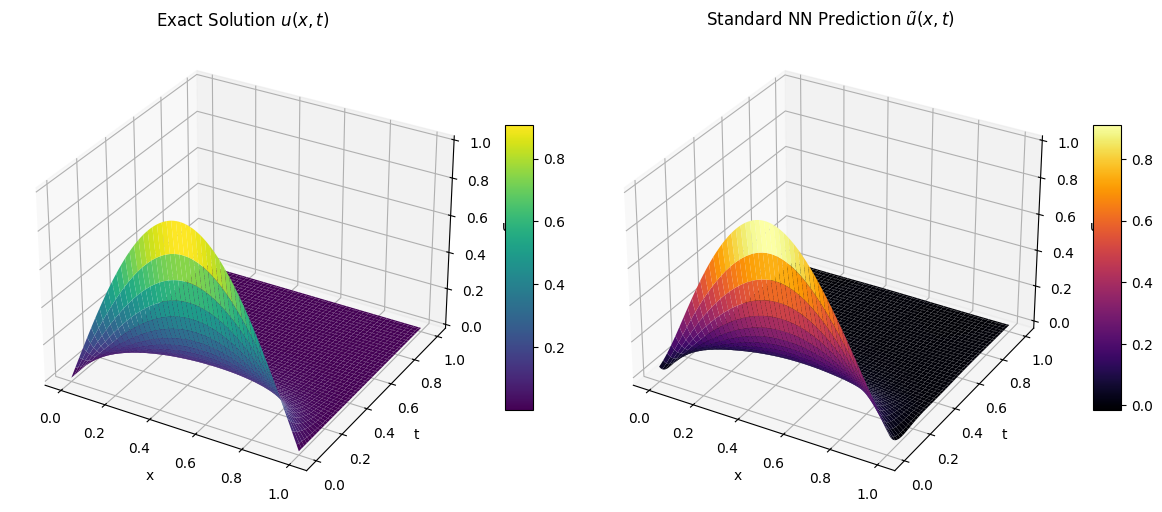

In [16]:
fig = plt.figure(figsize=(12, 6))

# Exact Solution Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X_grid, T_grid, u_exact_grid, cmap='viridis', edgecolor='none')
ax1.set_title("Exact Solution $u(x,t)$")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# Predicted Solution Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X_grid, T_grid, u_pred, cmap='inferno', edgecolor='none')
ax2.set_title("Standard NN Prediction $\\tilde{u}(x,t)$")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

## Calculating PDE Loss

In [23]:
num_points = 200

x_line = np.linspace(0, 1, num_points)
t_line = np.linspace(0, 1, num_points)
X_grid, T_grid = np.meshgrid(x_line, t_line)
x_test = X_grid.flatten().reshape(-1, 1)
t_test = T_grid.flatten().reshape(-1, 1)

test_features = tf.concat([
    tf.convert_to_tensor(x_test, dtype=tf.float32),
    tf.convert_to_tensor(t_test, dtype=tf.float32)
], axis=1)

u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_grid = u_exact_test.reshape(num_points, num_points)

In [24]:
u_pred_std = model(test_features).numpy().reshape(num_points, num_points)
u_pred_pinn = pinn_model(test_features).numpy().reshape(num_points, num_points)

In [25]:
def compute_pde_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u_pred, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u_pred, t)
    del tape
    alpha = 1.0
    residual = u_t - alpha * u_xx
    return tf.reduce_mean(tf.square(residual))

In [26]:
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)

residual_std = compute_pde_residual(model, x_test_tf, t_test_tf).numpy()
residual_pinn = compute_pde_residual(pinn_model, x_test_tf, t_test_tf).numpy()

In [28]:
print("Standard NN PDE Residual:  {:.6e}".format(residual_std))
print("PINN PDE Residual:         {:.6e}".format(residual_pinn))

Standard NN PDE Residual:  5.172031e-01
PINN PDE Residual:         1.801782e-03
